# Requirements

In [2]:
import pandas as pd
import numpy as np
import string
import re

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

from collections import Counter
from stop_words import get_stop_words
# from nltk.corpus import stopwords  # I DONT KNOW WHY BUT THIS IS NOT WORKING :(


from joblib import Parallel, delayed


In [3]:
import multiprocessing
multiprocessing.cpu_count()

16

In [4]:
STOP_WORDS = get_stop_words('english') 
STOP_WORDS[:10]

['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and']

In [35]:
# does not contain non
while "non" in STOP_WORDS: 
    STOP_WORDS.remove("non")
    print("non removed")

# Data Import

In [5]:
df = pd.read_csv("openlibrary_works.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4301727 entries, 0 to 4301726
Data columns (total 5 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   title     object
 1   authors   object
 2   covers    object
 3   subjects  object
 4   key       object
dtypes: object(5)
memory usage: 164.1+ MB


In [6]:
df.head()

,title,authors,covers,subjects,key
0,Promettre et écrire,"[""OL3965106A""]",[5420446],"[""History, Ancient"", ""Historiography"", ""Compar...",OL10000120W
1,Fortuny,"[""OL3965405A""]",[3140637],"[""Costume design"", ""Italy"", ""Biography"", ""Fash...",OL10000374W
2,Piercing,"[""OL3966705A""]",[3143297],"[""Body piercing"", ""History .""]",OL10001531W
3,Paradise & More,"[""OL92951A""]",[1591541],"[""Fiction"", ""History""]",OL1000568W
4,Une Ombre Au Tableau,"[""OL3975945A""]",[5204497],"[""Peinture"", ""Romans, nouvelles, etc. pour la ...",OL10009415W


# Subject extraction (EDA)

In [7]:
def extract_subjects(k, row, n_works, collated=True, report_freq=1*10**4):
    """Extracts subjects from the 'subjects' column of 'works' table from Open Libaray dump

    Args:
        k (int): Current row index being processed
        row (pd.DataFrame): Current row being processed
        n_works (int): Number of rows to process
        collated (bool, optional): Extract collated or non-collated subjects (see comments below). Defaults to True.
        report_freq (int, optional): Freqency to print progress {k/n_works}. Defaults to 1*10**4.
    """

    if collated: 
        # === COLLATED ===
        # Preserves multi-word subjects in data
        # e.g. ["Body piercing", "History ."] = ["body-piercing", "history"]

        # convert all to lowercase
        curr_subjects = row["subjects"].lower() 
        # extract all subjects from each subject array (text between "'s)
        curr_subjects = re.findall('"([^"]*)"', curr_subjects)
        # convert to np.array
        curr_subjects = np.array(curr_subjects)

        # remove all punctuation and leading/ trailing whitespaces
        curr_subjects = [
            subj.translate(str.maketrans('', '', string.punctuation))
                .strip()
            for subj in curr_subjects]
        # remove any empty strings
        while("" in curr_subjects): curr_subjects.remove("")
        # replace all spaces with "-"
        curr_subjects = [subj.replace(' ', '-') for subj in curr_subjects]

    else: 
        # === SPLIT === 
        # Splits each subject in data into single words
        # Treats each word in subject field as one subject
        # e.g. ["Body piercing", "History ."] = ["body", "piercing", "history"]

        # convert all to lowercase
        curr_subjects = row["subjects"].lower() 
        # remove all punctuation 
        curr_subjects = curr_subjects.translate(str.maketrans('', '', string.punctuation))
        # exception: keep non-fiction words together
        curr_subjects = re.sub('non fiction', 'non-fiction', curr_subjects)
        # split processed subjects string into array of individual words
        curr_subjects = curr_subjects.split()
        # remove all stopwords
        curr_subjects = [subj for subj in curr_subjects if not subj in STOP_WORDS]

    # === PROGRESS REPORT === 
    if k % (report_freq) == 0:
        print('{0:-8} / {1:}'.format(k, n_works))

    # === RETURN === 
    return(curr_subjects)


## Non-Truncated

In [7]:
N_WORKS = len(df.index) # 50000

print("Beginning subject extraction...")
subjects = Parallel(n_jobs=-1)(
    delayed(extract_subjects)(k, row, N_WORKS) for k, row in df[:N_WORKS].iterrows())
subjects = np.concatenate(subjects, axis=0)
print("Subject extraction complete.")

print("\nSample result:")
subjects[:10]

Beginning subject extraction...
       0 / 4301727
   10000 / 4301727
   20000 / 4301727
   30000 / 4301727
   40000 / 4301727
   50000 / 4301727
   60000 / 4301727
   70000 / 4301727
   80000 / 4301727
   90000 / 4301727
  100000 / 4301727
  110000 / 4301727
  120000 / 4301727
  130000 / 4301727
  140000 / 4301727
  150000 / 4301727
  160000 / 4301727
  170000 / 4301727
  180000 / 4301727
  190000 / 4301727
  200000 / 4301727
  210000 / 4301727
  220000 / 4301727
  230000 / 4301727
  240000 / 4301727
  250000 / 4301727
  260000 / 4301727
  270000 / 4301727
  280000 / 4301727
  290000 / 4301727
  300000 / 4301727
  310000 / 4301727
  320000 / 4301727
  330000 / 4301727
  340000 / 4301727
  350000 / 4301727
  360000 / 4301727
  370000 / 4301727
  380000 / 4301727
  390000 / 4301727
  400000 / 4301727
  410000 / 4301727
  420000 / 4301727
  430000 / 4301727
  440000 / 4301727
  450000 / 4301727
  460000 / 4301727
  470000 / 4301727
  480000 / 4301727
  490000 / 4301727
  500000 / 4301727

array(['history-ancient', 'historiography', 'comparative-method',
       'ancient-history', 'costume-design', 'italy', 'biography',
       'fashion-designers', 'body-piercing', 'history'], dtype='<U1433')

In [8]:
# unpack arrays to one string
subjects_str = ' '.join(np.ravel(subjects))
print("Complete.")

# save as txt file
text_file = open("allsubj_notrunc_100ksample.txt", "wt")
n = text_file.write(subjects_str)
text_file.close()

Complete.


##### Word Cloud

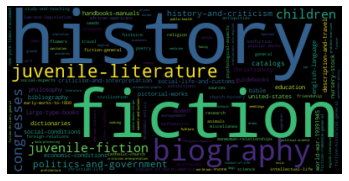

In [9]:
# create the wordcloud object
# https://stackoverflow.com/questions/59148244/keeping-words-together-in-wordcloud

word_could_dict = Counter(subjects)
wordcloud = WordCloud().generate_from_frequencies(word_could_dict)
# wordcloud.to_file("word_test.png")

# plot the wordcloud object
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()


In [10]:
# create a dictionary of word frequencies
sub_dictionary = word_could_dict
# sort the dictionary
word_freq = {k: v for k, v in sorted(
    sub_dictionary.items(), reverse=True, key=lambda item: item[1])}

# use words_ to print relative word frequencies
rel_freq = wordcloud.words_

In [11]:
rel_freq_df = pd.DataFrame.from_dict(
    rel_freq,
    orient='index',
    columns=["Freqency"]
)
rel_freq_df['Subject'] = rel_freq_df.index
rel_freq_df.reset_index(drop=True, inplace=True)
rel_freq_df


,Freqency,Subject
0,1.000000,history
1,0.761105,fiction
2,0.426065,biography
3,0.369501,juvenile-literature
4,0.225200,congresses
...,...,...
195,0.017386,kings-and-rulers
196,0.017257,moral-and-ethical-aspects
197,0.017072,natural-history
198,0.017065,technology


## Trucated

In [8]:
N_WORKS = len(df.index) # 50000

print("Beginning subject extraction...")
subjects = Parallel(n_jobs=-1)(
    delayed(extract_subjects)(k, row, N_WORKS, collated = False) for k, row in df[:N_WORKS].iterrows())
subjects = np.concatenate(subjects, axis=0)
print("Subject extraction complete.")

print("\nSample result:")
subjects[:10]

Beginning subject extraction...
       0 / 4301727
   10000 / 4301727
   20000 / 4301727
   30000 / 4301727
   40000 / 4301727
   50000 / 4301727
   60000 / 4301727
   70000 / 4301727
   80000 / 4301727
   90000 / 4301727
  100000 / 4301727
  110000 / 4301727
  120000 / 4301727
  130000 / 4301727
  140000 / 4301727
  150000 / 4301727
  160000 / 4301727
  170000 / 4301727
  180000 / 4301727
  190000 / 4301727
  200000 / 4301727
  210000 / 4301727
  220000 / 4301727
  230000 / 4301727
  240000 / 4301727
  250000 / 4301727
  260000 / 4301727
  270000 / 4301727
  280000 / 4301727
  290000 / 4301727
  300000 / 4301727
  310000 / 4301727
  320000 / 4301727
  330000 / 4301727
  340000 / 4301727
  350000 / 4301727
  360000 / 4301727
  370000 / 4301727
  380000 / 4301727
  390000 / 4301727
  400000 / 4301727
  410000 / 4301727
  420000 / 4301727
  430000 / 4301727
  440000 / 4301727
  450000 / 4301727
  460000 / 4301727
  470000 / 4301727
  480000 / 4301727
  490000 / 4301727
  500000 / 4301727

array(['history', 'ancient', 'historiography', 'comparative', 'method',
       'ancient', 'history', 'costume', 'design', 'italy'], dtype='<U129')

In [9]:
subjects_str = ' '.join(subjects)
print("Complete.")

# save as txt file
text_file = open("allsubj_split.txt", "wt")
n = text_file.write(subjects_str)
text_file.close()

Complete.


In [19]:
subjects_str[:100]

'history ancient historiography comparative method ancient history costume design italy biography fas'

### Word cloud

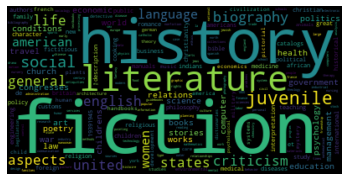

In [11]:
# create the wordcloud object
# https://stackoverflow.com/questions/59148244/keeping-words-together-in-wordcloud

word_could_dict = Counter(subjects)
wordcloud = WordCloud().generate_from_frequencies(word_could_dict)
# wordcloud.to_file("word_test.png")

# plot the wordcloud object
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

In [12]:
# create a dictionary of word frequencies
sub_dictionary = wordcloud.process_text(subjects_str)
# sort the dictionary
word_freq = {k: v for k, v in sorted(
    sub_dictionary.items(), reverse=True, key=lambda item: item[1])}

# use words_ to print relative word frequencies
rel_freq = wordcloud.words_


In [13]:
rel_freq_df = pd.DataFrame.from_dict(
    rel_freq,
    orient='index',
    columns=["Freqency"]
)
rel_freq_df['Subject'] = rel_freq_df.index
rel_freq_df.reset_index(drop=True, inplace=True)
rel_freq_df 


,Freqency,Subject
0,1.000000,fiction
1,0.692556,history
2,0.420839,literature
3,0.318238,juvenile
4,0.256928,social
...,...,...
195,0.021907,mathematical
196,0.021843,sports
197,0.021756,problems
198,0.021693,europe


In [32]:
for k,row in rel_freq_df.iterrows():
    if "non" in row[1]: print (row)

Freqency      0.031611
Subject     nonfiction
Name: 133, dtype: object


### Barcharts

[(0.0, 1.0)]

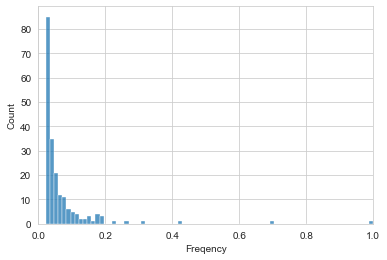

In [14]:
sns.set_style("whitegrid")
sns.histplot(data=rel_freq_df, x="Freqency").set(xlim=(0, 1))


/var/folders/fv/mxpj18zs55g_msjbhknhh0t00000gp/T/ipykernel_42264/603029288.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


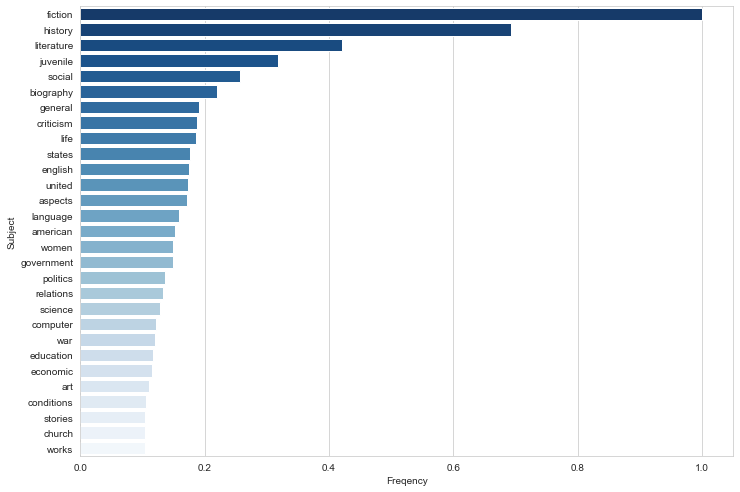

In [15]:
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)

sns.barplot(
    x="Freqency",
    y="Subject",
    data=rel_freq_df[rel_freq_df["Freqency"] > 0.1],
    palette="Blues_r",
    ax=ax
)

fig.show()


In [16]:
rel_freq_df.to_csv("freq.csv")

# Subject Selection

Preliminary subject genres are based on:
Paper: http://cs231n.stanford.edu/reports/2017/pdfs/814.pdf
Literature guide: https://blog.reedsy.com/book-genres/

In [ ]:
subj_mapping = {
    "fiction" : ["fiction","fictitious"],   # Fiction
    "fantasy" : ["fantasy"],   # Fantasy/ Magical Realism
    "mystery" : ["mystery","detective"],   # Mystery/ Horror/ Thriller & Suspense - crime
    "romance" : ["romance"],   # Romance
    "womens" : ["women"],   # Women’s
    "grapic_novel" : ["grapic","pictorial","picture"],   # Graphic Novel/ Comics
    "nonfiction" : ["nonfiction"],   # Nonfiction
    "biography" : ["biography"],   # Memoir & Autobiography/ Biography
    "dining" : ["dining","cooking","food"],   # Food & Drink
    "art" : ["art","poetry","music","architecture","design","arts","picture","photography"],   # Art & Photography
    "history" : ["history","war","historical","histoire"],   # History
    "humor" : ["humor"],   # Humor 
    "religion" : ["catholic","religion","church","religious","bible","christian","christianity","theology"],   # Religion & Spirituality
    "social_sci" : ["religious","culture","sociology","communication","civilization","public","religion","customs","social","criticism","government","politics","war","economic","management","world","administration"],   # Social Sciences
    "humanities" : ["culture","behavior","ethics","art","arts","customs","criticism","language","psychology","philosophy","therapy"],
    "business" : ["business", "economic","economics","finance","trade","administration","management"],
    "politics" : ["legislation","government","military","politics","war","economic","law","congresses","political","policy","international"],
    "sci_tech" : ["research","physics","science","chemistry","mathematics","mathematical","sciences","computer","computers","industrial","health","medical","engineering","environmental","architecture","technology"],   # Science & Technology
    "medicine" : ["health","nursing","medical","diseases","disease","medicine","animals"],   # Science & Technology
    "educational" : ["education","guidebooks","teaching","study","medical","bibliography","textbooks","research","manuals","handbooks","dictionaries","theory","animals"],   # Education/ guide/ how-to
    "childrens" : ["childrens","children","family","child","nursery","",""],   # Childrens
    "young_adult" : ["juvenile"]   # YA
}